In [3]:
#1.크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

url_list = make_urllist(2, 105, 20231128)
print('뉴스 기사의 개수: ',len(url_list))
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

뉴스 기사의 개수:  40


In [11]:
#뉴스페이퍼 페키지를 활용하여 기사 제목 및 파싱 진행
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [6]:
data = make_data(url_list, 105) #- 상위 10개만 출력해봅니다.

In [12]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [13]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [14]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [16]:
df = make_total_data(1, code_list, 20231128)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [15]:
print('뉴스 기사의 개수: ',len(df))

NameError: name 'df' is not defined

In [22]:
df.sample(10)

,news,code
18,생성형 AI 시대…“데이터센터 열을 식혀라”,IT/과학
13,"HK이노엔·고용노동부, 안전문화 확산 위한 업무협약 체결",생활/문화
7,유튜버 일탈 어디까지…모텔서 수면제 투약하고 방송한 20대女,사회
18,운동 효과 확 높이려면… 끝나고 ‘이것’ 꼭 해야,생활/문화
10,"코웨이 환경기술연구소, 22년 연속 KOLAS 공인시험기관 인정",IT/과학
19,‘카카오 카르텔’ 의혹 수면 위로...치부 전면에 드러낸 김범수 최측근,IT/과학
19,[포토] ‘2023 장애인 먼저 실천상’ 시상식,사회
5,"유니스트, ‘세계에서 가장 영향력 있는 연구자’ 9명",IT/과학
2,동명이인 환자 명의로 '의료용 마약류' 처방받은 의사,사회
17,작곡계 노벨상 받은 진은숙… 베를린 필 ‘진 에디션’ 발매,생활/문화


In [ ]:
df = make_total_data(10, code_list, 20240101)

In [ ]:
df.sample(10)

In [17]:
import os

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/merged_file.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,"포스코 효자아트홀, 겨울방학 특선 영화 상영",사회
1,"""신혼집 집들이서 친구들과 전여친 흉본 남편, 이혼 고민된다""",사회
2,"""목숨 끊어져도 무죄""라던 '딸 친구 성폭행' 통학차 기사의 최후",사회
3,"고령군, 지역내 총생산 증가율 1위",사회
4,생때같은 자식 살해·암매장한 ‘비정한 엄마들’…잇단 중형 선고,사회


In [18]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_31/3649439000.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0                포스코 효자아트홀 겨울방학 특선 영화 상영
1        신혼집 집들이서 친구들과 전여친 흉본 남편 이혼 고민된다
2       목숨 끊어져도 무죄라던 딸 친구 성폭행 통학차 기사의 최후
3                      고령군 지역내 총생산 증가율 위
4         생때같은 자식 살해암매장한 비정한 엄마들잇단 중형 선고
                      ...               
1081     정유사  생산 근거 마련됐다상용화 핵심은 경제성수요 확대
1082                  펄어비스 에서 붉은사막 영상 시연
1083        우주개발 경쟁이 촉발한 로켓 발사 오존층 파괴 우려
1084        넷마블 공식 틱톡 팔로워 만명 돌파실버 어워드 수상
1085       페이커이상혁모든 대회 우승이 목표값진 한 해 만들 것
Name: news, Length: 1086, dtype: object

In [19]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [20]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  1083


<AxesSubplot:>

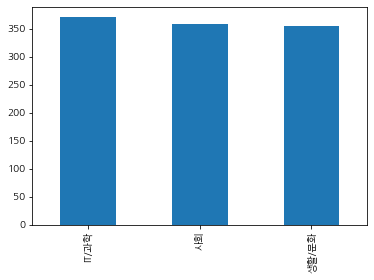

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [22]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    370
1     사회    359
2  생활/문화    354


In [38]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속됐다서울', '제주경찰', '서는', '상하', '어', '혐의', '로', '씨', '를', '구속해', '수사', '하고', '있', '다', '고', '일', '밝혔다씨', '는', '지난달', '일', '피하', '어', '여성', '을', '인근', '지하철', '역', '에서부터', '따르', '아', '가', '아', '폭행', '을', '시도', '하', '려', '다가', '도망가', 'ㄴ', '혐의', '를', '받는다피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '아며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포됐다피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었다']


In [24]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [26]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [27]:
text_data = preprocessing(df['news'])
print(text_data[0])

포스코 효자 아트홀 겨울 방학 특선 영화 상영


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [29]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [30]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 812
테스트용 뉴스 기사의 개수 :  271
훈련용 레이블의 개수 :  812
테스트용 레이블의 개수 :  271


In [31]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [32]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [33]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [34]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [35]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [36]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.72      0.87      0.79        98
          사회       0.74      0.78      0.76        83
       생활/문화       0.71      0.51      0.59        90

    accuracy                           0.72       271
   macro avg       0.72      0.72      0.71       271
weighted avg       0.72      0.72      0.71       271



In [ ]:
#Hannanum, Kkma, Komoran, Okt
#1. Hannanum -> 너무 느려서 안 돌아감...
from konlpy.tag import Hannanum
tokenizer = Hannanum()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

text_data = preprocessing(df['news'])
print(text_data[0])

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속됐다서울', '제주경찰', '서는', '상하', '어', '혐의', '로', '씨', '를', '구속해', '수사', '하고', '있', '다', '고', '일', '밝혔다씨', '는', '지난달', '일', '피하', '어', '여성', '을', '인근', '지하철', '역', '에서부터', '따르', '아', '가', '아', '폭행', '을', '시도', '하', '려', '다가', '도망가', 'ㄴ', '혐의', '를', '받는다피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '아며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포됐다피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었다']


In [ ]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup

csv_path = os.getenv("HOME") + "/aiffel/news_crawler/merged_file.csv"
df = pd.read_table(csv_path, sep=',')

# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

from konlpy.tag import Mecab  
tokenizer = Mecab()


stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수',
             '무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스',
             '날', '무상', '원', '억', '도', '어', '나', '것', '살',
             '야', '만', '중', '라', '아', '기', '찬', '간', '상', '개', '곳', '어', '로', '합니다', '와',
             '년', '새', '서', '화', '공개', '환', '화', '서']

# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
    text_data = []

    for index, sentence in enumerate(data):
        try:
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(' '.join(temp_data))
        except Exception as e:
#             print(f"Error at index {index}: {sentence}\nError: {e}")
            text_data.append('')  # Append an empty string or some placeholder
            continue  # Continue with the next iteration

    return text_data

text_data = preprocessing(df['news'])

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#회고:
#1. 다양한 토크나이저를 사용하고 싶었지만 시간이 너무 많이 소요되어 모두 테스트 해볼 수 없었다.
#2. 기존 날짜와 다른 날짜를 합쳐 데이터를 늘렸더니 정확도가 높아졌다.
#3. 전체적인 로직을 이해하기 아직 어렵고 낯설다.
#4. 크롤링 속도가 느려서 답답한 면이 있었다.